In [1]:
import os
import random
import cv2
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from PIL import Image
from pathlib import Path

In [2]:
# !pip install tqdm

In [3]:
# TODO: 1. Привести изображение к чернобелому виду. 
# TODO: 2. Проверить помещается ли изображение в нейронную сеть. 
# TODO: 3. Разрезать изображение на кусочки и подавать его в нейронную сеть по частям. 
#       4. Научить склеивать изображения, после прохода через нейронную сеть. 

In [4]:
DATA_ROOT = '../pages/'

class_names = {'Void':0,'DLSignature':1,'DLLogo':2}

# IM_SIZE = (1200,1600)
IM_SIZE = (600,800)

In [5]:
images_path = Path(DATA_ROOT+'source/')
annotation_path = Path(DATA_ROOT+'truth/')

In [6]:
# <DL_ZONE gedi_type="DLLogo"      id="None" col="92" row="167" width="755" height="228"> </DL_ZONE>
# <DL_ZONE gedi_type="DLSignature" id="None" col="821" row="1422" width="757" height="183" Overlapped="Yes" AuthorID="Koplow, M.G."> </DL_ZONE>

In [7]:
def filelist(root, file_type):
    """Функция возвращает полностью квалифицированный список файлов в директории"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

In [8]:
def generate_df(path):
    anno_list = []
    annotations = filelist(path, '.xml')
    ns = {'doc': "http://lamp.cfar.umd.edu/GEDI"}

    for anno_path in annotations:
        anno = {}
        root = ET.parse(anno_path).getroot()

        document  = root.find('doc:DL_DOCUMENT',ns)

        doc_attrib = document.attrib

        anno['doc_name'] = Path(str(images_path) + '/'+ doc_attrib['src'])
        anno['pages'] = doc_attrib['NrOfPages']
        #=================================================================#
        page = document.find('doc:DL_PAGE',ns)
        page_attrib = page.attrib
        # anno['page_name'] = Path(str(images_path) + '/'+ page_attrib['src'])
        anno['page_id'] = page_attrib['pageID']
        anno['width'] = int(page_attrib['width'])#.astype(np.int)
        anno['height'] = int(page_attrib['height'])#.astype(np.int)
        #=================================================================#

        zone = page.find('doc:DL_ZONE',ns)
        # anno['zone_type'] = ''
        if zone is not None:
            zone_attrib = zone.attrib

            anno['zone_type'] = zone_attrib['gedi_type']
            # anno['zone_id'] = zone_attrib['id']
            anno['zone_col'] = int(zone_attrib['col']) #.astype(np.int)
            anno['zone_row'] = int(zone_attrib['row']) #.astype(np.int)
            anno['zone_width'] = int(zone_attrib['width'])#.astype(np.int)
            anno['zone_height'] = int(zone_attrib['height'])#.astype(np.int)
            # if anno['zone_type'] == "DLSignature":
            #     anno['zone_Overlapped'] = zone_attrib['Overlapped']
            #     anno['zone_AuthorID'] = zone_attrib['AuthorID']
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [9]:
df = generate_df(annotation_path)
df

,doc_name,pages,page_id,width,height,zone_type,zone_col,zone_row,zone_width,zone_height
0,../pages/source/mcm24f00_2.tif,1,1,2592,3300,NaN,NaN,NaN,NaN,NaN
1,../pages/source/nsr05f00_2.tif,1,1,2592,3300,NaN,NaN,NaN,NaN,NaN
2,../pages/source/adh36e00-page2_2.tif,1,1,2560,3246,DLSignature,1232.0,2399.0,896.0,431.0
3,../pages/source/jon00a00.tif,1,1,2504,3111,DLSignature,1374.0,2478.0,668.0,304.0
4,../pages/source/byd23a00.tif,1,1,1728,2292,DLSignature,837.0,1014.0,302.0,135.0
...,...,...,...,...,...,...,...,...,...,...
995,../pages/source/mht90f00-var-full_1.tif,1,1,1200,1575,DLSignature,170.0,1049.0,394.0,65.0
996,../pages/source/qpb44c00-page03_1.tif,1,1,2592,3300,NaN,NaN,NaN,NaN,NaN
997,../pages/source/hty24f00-page02_1.tif,1,1,2592,3300,NaN,NaN,NaN,NaN,NaN
998,../pages/source/ahs60f00.tif,1,1,1200,1575,DLSignature,706.0,1110.0,202.0,52.0


In [10]:
df['zone_type'].value_counts()

DLSignature    595
DLLogo          65
Name: zone_type, dtype: int64

In [11]:
# Заполним пропуски. 
df.loc[(df['zone_type'].isnull()),'zone_type'] = 'Void'

# Приведем все классы к цыфровому виду.
df['zone_type'] = df['zone_type'].apply(lambda x: class_names[x])

In [12]:
df['zone_type'].value_counts() 

1    595
0    340
2     65
Name: zone_type, dtype: int64

In [13]:
# Изображений с логотипами очень мало.
# Есть большая вероятность, что на них нейронная сеть будет очень плохо обучаться.  

### Номер страницы будем извлекать из названия.

In [14]:
df.describe()

,width,height,zone_type,zone_col,zone_row,zone_width,zone_height
count,1000.000000,1000.000000,1000.000000,660.000000,660.000000,660.000000,660.000000
mean,2125.276000,2735.698000,0.725000,808.927273,1308.813636,434.856061,143.706061
std,585.006178,724.824685,0.574199,414.598628,698.596510,229.106523,77.788057
min,1200.000000,1575.000000,0.000000,29.000000,1.000000,69.000000,35.000000
25%,1728.000000,2292.000000,0.000000,561.000000,813.750000,264.000000,86.000000
50%,2544.000000,3258.000000,1.000000,715.000000,1211.500000,365.500000,124.500000
75%,2592.000000,3300.000000,1.000000,1150.500000,1852.500000,596.500000,181.000000
max,2720.000000,3584.000000,2.000000,1830.000000,3058.000000,1095.000000,579.000000


In [15]:
# Получить изображения.

In [16]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BAYER_BG2GRAY)

def create_mask(bb, x, class_index):
    """Создаем маску для bounding box'a такого же шейпа как и изображение"""
    rows,cols, _ = x.shape
    y_ind = np.zeros((rows, cols)) # Нужно больше каналов.
    y_cat = np.zeros((rows, cols , len(class_names)-1))
    bb = bb.astype(np.int)

    if class_index > 0:
        y_ind[bb[1]:bb[3]+bb[1],bb[0]: bb[2]+bb[0]] = class_index # У нас два класса. И, для каждого из них нужно сделать маску.
        y_cat[bb[1]:bb[3]+bb[1],bb[0]: bb[2]+bb[0], class_index-1] = 1
    return y_cat, y_ind

def create_bb_array(x,class_index):
    """Генерируем массив bounding box'a из столбца train_df"""
    if class_index == 0:
        res = np.array([0,0,0,0]) 
    else:
        res = np.array([x[0],x[1],x[2],x[3]])      
    return res

#========================================================================================
def mask_to_bb(y_cat):
    """Конвертируем маску Y в bounding box'a, принимая 0 как фоновый ненулевой объект """
    bbx = []
    for i in range(len(class_names)-1):
        cols, rows = np.nonzero(y_cat[..., i])
        if len(cols) == 0:
           bbx.append([0,0,0,0])
        else:
           top_row = np.min(rows)
           left_col = np.min(cols)
           bottom_row = np.max(rows)
           right_col = np.max(cols)
           bbx.append([top_row, left_col, bottom_row-top_row, right_col-left_col])
    return np.array(bbx, dtype=np.float32)
    
#========================================================================================
def resize_image_bb(img_size,img_new_size, bb):
    width, height =  img_size[0], img_size[1]
    new_width, new_height  = img_new_size[0], img_new_size[1]
    height_scale = new_height/height
    width_scale = new_width/width
    bb[0] *= width_scale 
    bb[1] *= height_scale
    bb[2] *= width_scale
    bb[3] *= height_scale
    return bb 

In [17]:
df.iloc[54].zone_type

1

In [18]:
def view_page(number):
    print(str(df['doc_name'][number]))
    im = read_image(df.values[number][0])
    print(im.shape)
    class_index = df.iloc[number].zone_type
    
    bb = create_bb_array(df.values[number][6:], class_index)
    
    y_cat, y_ind = create_mask(bb, im, class_index)
    bbx = mask_to_bb(y_cat)
    
    rect = plt.Rectangle((bb[0], bb[1]), bb[2], bb[3],fill=False, color='red')
    fig, ax = plt.subplots(1,2,figsize=(10,7))
    ax[0].imshow(im)
    ax[0].add_patch(rect)
    ax[1].imshow(y_ind)
    plt.show()

In [19]:
view_page(58)

../pages/source/pxp81f00.tif


error: OpenCV(4.5.3) /tmp/pip-req-build-afu9cjzs/opencv/modules/imgproc/src/demosaicing.cpp:1699: error: (-215:Assertion failed) scn == 1 && dcn == 1 in function 'demosaicing'


../pages/source/cxk72e00-page03_1.tif


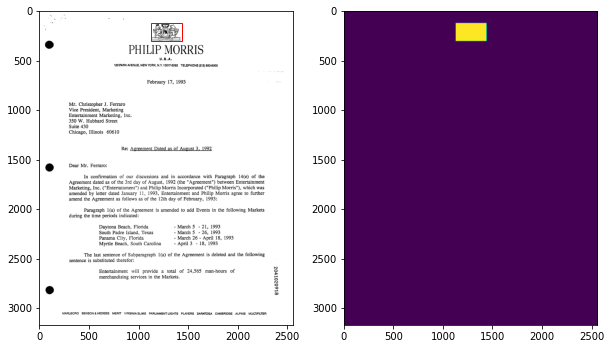

In [ ]:
view_page(24)

../pages/source/jon00a00.tif


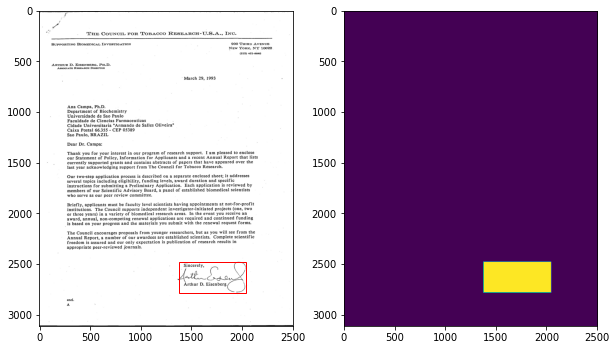

In [ ]:
view_page(3)

In [22]:
# Приведем все изображения к единому размеру.
# При обучении модели будем подавать изображения в сеть по частям.

# Т.к. лого и подписи врядли попадут в одни и теже квадраты, то будем отправлять 
# то будем применять самый простой алгоритм обучения. А, затем все склеим в вернем результаты.

In [23]:
# Отобразить извлеченные объекты на изображении.

Могут быть одинаковы изображения, Просто на одних размечены только подписи, ан на других логотоипы.

In [24]:
# Попробуем изменить размер исходного изображения. 
# Это упростит процесс расплзнавания.

In [25]:
new_image_paths = []
new_mask_paths = []
class_index = []
old_width = []
old_height = []
zone_col = []
zone_row = []
zone_width = []
zone_height = []

image_path_resized = Path(DATA_ROOT+'source_prepare')
Path.mkdir(image_path_resized, exist_ok=True)

mask_path_resized = Path(DATA_ROOT+'mask_prepare')
Path.mkdir(mask_path_resized, exist_ok=True)

for index, row in tqdm(df.iterrows()):
    try: 
        im_path = Path(row['doc_name'])
        # Проверим. существуетли файл. 
        img = cv2.imread(str(im_path))

        img_height = img.shape[0]
        img_width = img.shape[1]

        im_resized = cv2.resize(img, IM_SIZE)
        new_image_path = str(image_path_resized/im_path.parts[-1])
        cv2.imwrite(new_image_path, im_resized)
#=============================================================
        curren_class = row['zone_type']
        bb = create_bb_array(row.values[6:], curren_class)
        # y_cat, _ = create_mask(bb, img, curren_class)
        bb_resized = resize_image_bb((img_width,img_height),IM_SIZE,bb)
        # название маски
#=============================================================
        col,row, width, height = bb_resized
      
        new_image_paths.append(new_image_path)
        old_height.append(img_height)
        old_width.append(img_width)
        class_index.append(curren_class)
        zone_col.append(col)
        zone_row.append(row)
        zone_width.append(width)
        zone_height.append(height)
        
    except Exception as ex:
        print(index, ex)
    
df_resize = pd.DataFrame({'doc_name':new_image_paths,
                          'old_width': old_width, 'old_height': old_height,
                          'zone_type': class_index, 
                          'zone_col': zone_col, 'zone_row':zone_row, 
                          'zone_width':zone_width, 'zone_height':zone_height})

1000it [00:33, 29.92it/s]


# Составить таблицу для хранения координат объектов на изображении. 

In [26]:
df_resize.head()

,doc_name,old_width,old_height,zone_type,zone_col,zone_row,zone_width,zone_height
0,../pages/source_prepare/mcm24f00_2.tif,1200,1575,0,0.000000,0.000000,0.000000,0.000000
1,../pages/source_prepare/nsr05f00_2.tif,1200,1575,0,0.000000,0.000000,0.000000,0.000000
2,../pages/source_prepare/adh36e00-page2_2.tif,2560,3246,1,288.750000,591.250770,210.000000,106.223044
3,../pages/source_prepare/jon00a00.tif,2504,3111,1,329.233227,637.222758,160.063898,78.174221
4,../pages/source_prepare/byd23a00.tif,1728,2292,1,290.625000,353.926702,104.861111,47.120419


In [27]:
def view_page_1(number):
    print(str(df_resize['doc_name'][number]))
    im = cv2.imread(str(df_resize.values[number][0]))
    class_index = df_resize.iloc[number].zone_type
    
    bb = create_bb_array(df_resize.values[number][4:], class_index)
    
    y_cat, y_ind = create_mask(bb, im, class_index)
    bbx = mask_to_bb(y_cat)

    rect = plt.Rectangle((bb[0], bb[1]), bb[2], bb[3],fill=False, color='red')
    fig, ax = plt.subplots(1,2,figsize=(10,7))
    ax[0].imshow(im)
    ax[0].add_patch(rect)
    ax[1].imshow(y_ind)
    plt.show()

../pages/source_prepare/jon00a00.tif


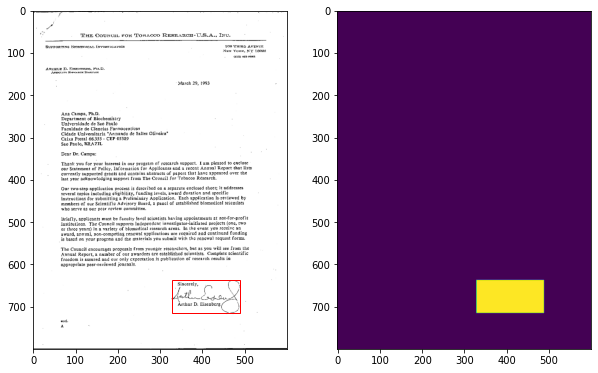

In [28]:
view_page_1(3)

In [29]:
# Разделим выборку на тестовую и тренировочную.

In [30]:
# Создадим заготовку нейронной сети.

# Обучим нейронную сеть поочередно на одной и другой выборках. 

In [ ]:
X_train_gray = X_train[0].copy()
print("X_train_grey image data shape =", X_train_gray.shape)
X_train_gray = cv2.cvtColor(X_train_gray, cv2.COLOR_BGR2GRAY)
print("X_train_grey image data shape =", X_train_gray.shape)

np.reshape(...,-1)# Помоему так было.

In [ ]:
num_classes = len(classes_df)

In [ ]:
# create the base pre-trained model
# base_model = ResNet50(weights='imagenet', input_shape=(256,256,3), include_top=False)
base_model = VGG16(weights='imagenet', input_shape=(256,256,3), include_top=False)
 
base_out = base_model.output

up = UpSampling2D(32, interpolation='bilinear')(base_out)
conv = Conv2D(num_classes, (3,3),padding='same')(up)
conv = Activation('softmax')(conv)

model = Model(inputs=base_model.input, outputs=conv)

In [ ]:
for X_test, y_test in keras_generator(test_df,batch_size=5):
  break

In [ ]:
def show_predictions(model,class_index=None):
    pred_mask = model.predict(sample_image[None])[0]
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 8))
    if not  class_index: 
      sample_m = LayersToRGBImage(sample_mask)
      pred_m = LayersToRGBImage(pred_mask)
      
    else:
      sample_m = sample_mask[...,class_index]
      pred_m = pred_mask[...,class_index]>0.5
      print('Class_Name:',classes_df.iloc[class_index][0])

    # plt.imshow(mask)
    ax[0].imshow(sample_image)
    ax[1].imshow(sample_m)
    ax[2].imshow(pred_m)
    plt.show()

class DisplayCallback(keras.callbacks.Callback):
    def __init__(self, patience=1):
        super().__init__()
        self.patience = patience
    
    def on_train_begin(self, logs=None):
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        self.wait += 1
        if self.wait >= self.patience:
            # clear_output(wait=True)
            show_predictions(self.model,class_index=17)
            print(f'\nSample Prediction after epoch {epoch+1}')
            self.wait = 0

In [ ]:
Создадим генератор для подачи изображений в сеть.

In [ ]:
show_predictions(model,class_index=17)

In [ ]:
checkpoint_best = keras.callbacks.ModelCheckpoint('model_best.h5',
                                                  monitor='val_loss',
                                                  verbose=0,
                                                  save_best_only=True,
                                                  save_weights_only=False,
                                                  mode='auto',
#                                                 period=1,
                                                 )

checkpoint_last = keras.callbacks.ModelCheckpoint('model_last.h5',
                                                  monitor='val_loss',
                                                  verbose=0,
                                                  save_best_only=False,
                                                  save_weights_only=False,
                                                  mode='auto',
#                                                 period=1
                                                 )


callbacks = [checkpoint_best, checkpoint_last,DisplayCallback(patience=1)]


adam = keras.optimizers.Adam(learning_rate=0.001)

model.compile(adam, loss='categorical_crossentropy')

In [ ]:
# create the base pre-trained model
# base_model = ResNet50(weights='imagenet', input_shape=(256,256,3), include_top=False)
base_model = VGG16(weights='imagenet', input_shape=(256,256,3), include_top=False)

for layer in base_model.layers[:-5]:
    layer.trainable = False

base_out = base_model.output

In [ ]:
base_model.summary()

In [ ]:
conv1 = base_model.get_layer('block1_conv2').output
conv2 = base_model.get_layer('block2_conv2').output
conv3 = base_model.get_layer('block3_conv2').output
conv4 = base_model.get_layer('block4_conv2').output
conv5 = base_model.get_layer('block5_conv2').output

In [ ]:
up1 = UpSampling2D(size=(2, 2),interpolation='bilinear')(conv5)
conc_1 = Concatenate()([up1,conv4])
conv_conc_1 = Conv2D(256,(3,3),padding='same')(conc_1)
conv_conc_1 = BatchNormalization()(conv_conc_1)
conv_conc_1 = Activation('relu')(conv_conc_1)

up2 = UpSampling2D(size=(2, 2),interpolation='bilinear')(conv_conc_1)
conc_2 = Concatenate()([up2,conv3])
conv_conc_2 = Conv2D(64,(3,3),padding='same')(conc_2)
conv_conc_2 = BatchNormalization()(conv_conc_2)
conv_conc_2 = Activation('relu')(conv_conc_2)

up3 = UpSampling2D(size=(2, 2),interpolation='bilinear')(conv_conc_2)
conc_3 = Concatenate()([up3,conv2])
conv_conc_3 = Conv2D(64,(3,3),padding='same')(conc_3)
conv_conc_3 = BatchNormalization()(conv_conc_3)
conv_conc_3 = Activation('relu')(conv_conc_3)

up4 = UpSampling2D(size=(2, 2),interpolation='bilinear')(conv_conc_3)
conc_4 = Concatenate()([up4,conv1])
conv_conc_4 = Conv2D(32,(3,3),padding='same')(conc_4)
conv_conc_4 = BatchNormalization()(conv_conc_4)
conv_conc_4 = Activation('relu')(conv_conc_4)

# up = UpSampling2D(2, interpolation='bilinear')(conv_conc_4)
conv = Conv2D(num_classes, (3, 3), padding='same')(conv_conc_4)
conv = Activation('softmax')(conv)

# model = Model(inputs=inp, outputs=result)

model = Model(inputs=base_model.input, outputs=conv)

In [ ]:
adam = keras.optimizers.Adam(learning_rate=0.001)

model.compile(adam, loss='categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
batch_size = 4
history = model.fit(keras_generator(train_df,batch_size),
              steps_per_epoch=100,
              epochs=5,
              verbose=1,
              callbacks=callbacks,
              # validation_data=keras_generator(test_df,batch_size),
              # validation_steps=50,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

In [ ]:
loss = history.history["val_loss"]
acc = history.history["val_accuracy"] #accuracy

plt.plot(loss)
plt.plot(acc)

plt.show

In [ ]:
pred = model.predict(X_test)

In [ ]:
show_predictions(model)

In [ ]:
# Прогоним модель и посмотрим в каком варианте у нас изображение получится на выходе.